In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.exceptions import AxisError
import pandas as pd
from scipy import stats

from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData, Integer, String, insert, select

engine = create_engine("sqlite+pysqlite:///GPSdata1.db", echo=False)

metadata_obj = MetaData()

players_table = Table("players", metadata_obj, autoload_with=engine)
sessions_data_table = Table("sessions_data", metadata_obj, autoload_with=engine)

In [30]:
# Sort a list of x and corresponding y corrdinates by the x coordinate, ascending
def bubblesort_by_x(x_coords, y_coords) -> tuple[np.ndarray, np.ndarray]:
    for n in range(len(x_coords) - 1, 0, - 1 ):

        swapped = False

        for i in range(n):
            if x_coords[i] > x_coords[i + 1]:
                
                x_coords[i], x_coords[i + 1] = x_coords[i + 1], x_coords[i]
                y_coords[i], y_coords[i + 1] = y_coords[i + 1], y_coords[i]

                swapped = True

        if not swapped:
            break

    return (x_coords, y_coords)


def interpolate_2D_array(arr, x_val: float|int) -> float:
    if not isinstance(arr, np.ndarray):
        raise TypeError("Input must be an ndarray")
    try:
        if not arr.shape[1] == 2:
            raise AxisError("Array shape must be (n,2)")
    except IndexError:
        raise AxisError("Array shape must be (n,2)")
    
    intercept = 0

    for i in range(0, len(arr) - 1):
        x, y = arr[i]
        next_x, next_y = arr[i+1]

        if x < x_val and next_y >= x_val:
            intercept = (x + next_x) / 2
            return intercept

In [31]:
measure = "HSR/min"
measures = sessions_data_table.columns
HSR_column = measures[measure]

with engine.connect() as conn:
    stmt = (
        select(players_table.c.team, players_table.c.position, HSR_column)
        .join(sessions_data_table, players_table.c.id == sessions_data_table.c.player_id)
        .order_by(players_table.c.team)
    )

    data = conn.execute(stmt).mappings().all()

df = pd.DataFrame(data)



In [66]:
def generate_RPs_team_row(measure: str, pallette: str, show_stdv: bool):
    g = sns.FacetGrid(df, row="team", hue="team", row_order=["1st", "U23", "U18", "U17"], height=1.5, aspect=5, palette=sns.color_palette(pallette))
    g.map(sns.kdeplot, measure, bw_adjust=1, fill=True, alpha=.2, lw=2)


    for i, ax in enumerate(g.axes.flat):
        ax.text(0.01, 0.8, g.row_names[i],
                fontsize=12, transform = ax.transAxes)
        ax.set_xlim(0, max(df[measure]))

    # add mean lines   
    if(show_stdv):     
        for i, ax in enumerate(g.axes.flat):
            for j, collection in enumerate(ax.collections):

                # Mean required to calulate x position of mean line
                df_p = df[ (df["team"] == g.row_names[i])]
                mean = df_p[measure].mean()
                stdv = np.std(df_p[measure])
                
                # vertices need to have y=0 coords filtered out for interp to work
                vertices = collection.get_paths()[0].vertices
                vertices = vertices[vertices.T[1] > 0]

                # As row order has been changed, face color needs to be indexced from collection and not theme
                face_color = collection.get_facecolor()[j]
                face_color[3] *= 1.5
                R,G,B,A = face_color
                # bubble sort to reduce risk of stack overflow?
                x_coords, y_coords = bubblesort_by_x(vertices.T[0], vertices.T[1])
                mean_height = np.interp(mean, x_coords, y_coords)
                stdm_height = np.interp(mean - stdv, x_coords, y_coords)
                stdp_height = np.interp(mean + stdv, x_coords, y_coords)

                ax.fill_between(x_coords, 0, y_coords, where=(mean - stdv <= x_coords) & (x_coords <= mean + stdv), interpolate=False, facecolor=face_color)
                
                ax.vlines(mean,0,mean_height, ls=":", colors=[R,G,B, 1])

                # ax.vlines(mean - stdv,0,stdm_height, ls=":", colors=sns.color_palette("bright")[j])
                # ax.vlines(mean + stdv,0,stdp_height, ls=":", colors=sns.color_palette("bright")[j])
            
            
        
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.5)
    g.figure.suptitle(f"pallette: {pallette}")
    g.set_titles("")
    # Remove axes details that don't play well with overlap
    g.set(yticks=[], ylabel="")
    g.despine(bottom=False, left=True)
    # g.add_legend(title="Position", loc="upper right", fontsize=12)
    g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)


def generate_RPs_position_row(measure: str, pallette: str, show_stdv: bool):
    g = sns.FacetGrid(df, row="position", hue="position", height=1.5, aspect=5, palette=sns.color_palette(pallette))
    g.map(sns.kdeplot, measure, bw_adjust=1, fill=True, alpha=.2, lw=2)


    for i, ax in enumerate(g.axes.flat):
        ax.text(0.01, 0.8, g.row_names[i],
                fontsize=12, transform = ax.transAxes)
        ax.set_xlim(0, max(df[measure]))

    # add mean lines
    if(show_stdv):        
        for i, ax in enumerate(g.axes.flat):
            for j, collection in enumerate(ax.collections):

                # Mean required to calulate x position of mean line
                df_p = df[ (df["position"] == g.row_names[i])]
                mean = df_p[measure].mean()
                stdv = np.std(df_p[measure])
                
                # vertices need to have y=0 coords filtered out for interp to work
                vertices = collection.get_paths()[0].vertices
                vertices = vertices[vertices.T[1] > 0]

                # As row order has been changed, face color needs to be indexced from collection and not theme
                face_color = collection.get_facecolor()[j]
                face_color[3] *= 1.5
                R,G,B,A = face_color
                # bubble sort to reduce risk of stack overflow?
                x_coords, y_coords = bubblesort_by_x(vertices.T[0], vertices.T[1])
                mean_height = np.interp(mean, x_coords, y_coords)
                stdm_height = np.interp(mean - stdv, x_coords, y_coords)
                stdp_height = np.interp(mean + stdv, x_coords, y_coords)

                ax.fill_between(x_coords, 0, y_coords, where=(mean - stdv <= x_coords) & (x_coords <= mean + stdv), interpolate=False, facecolor=face_color)
                
                ax.vlines(mean,0,mean_height, ls=":", colors=[R,G,B, 1])

                # ax.vlines(mean - stdv,0,stdm_height, ls=":", colors=sns.color_palette("bright")[j])
                # ax.vlines(mean + stdv,0,stdp_height, ls=":", colors=sns.color_palette("bright")[j])
            
            
        
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.5)
    # Remove axes details that don't play well with overlap
    g.figure.suptitle(f"pallette: {pallette}")
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=False, left=True)
    # g.add_legend(title="Position", loc="upper right", fontsize=12)
    g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)

 83%|████████▎ | 20/24 [00:16<00:02,  1.37it/s]g:\GPSProject\.venv\Lib\site-packages\seaborn\axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)
100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


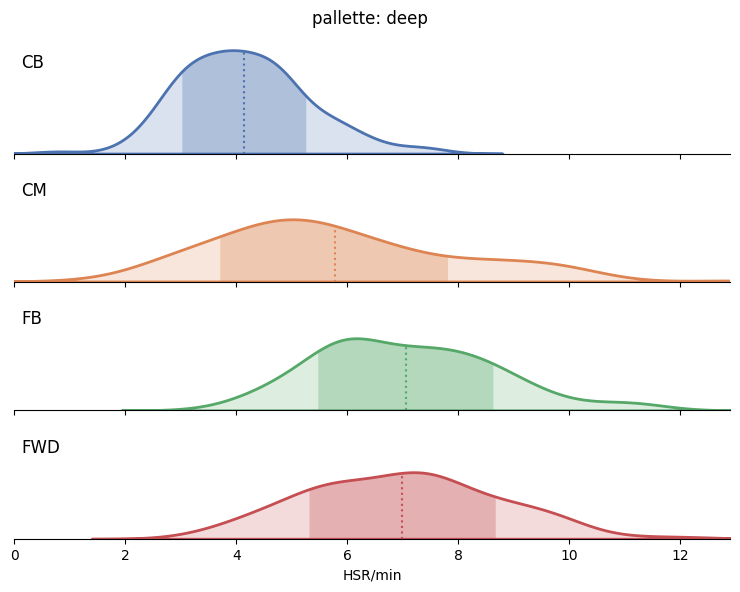

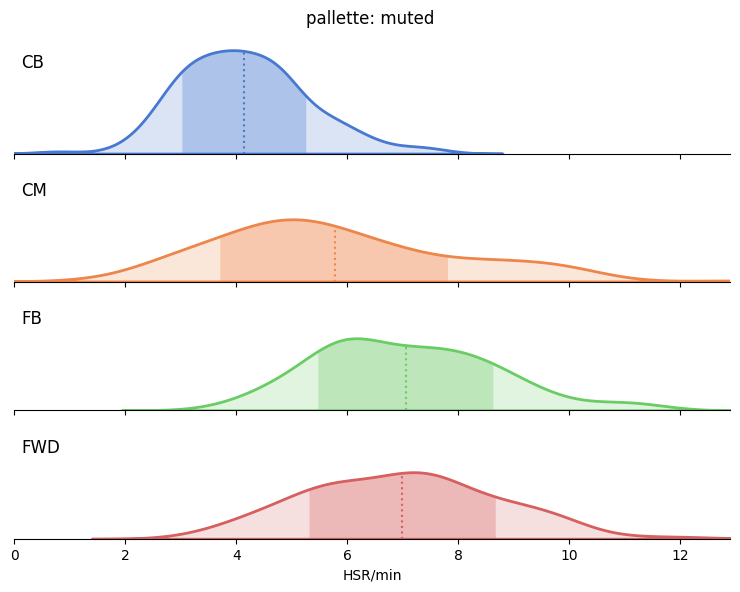

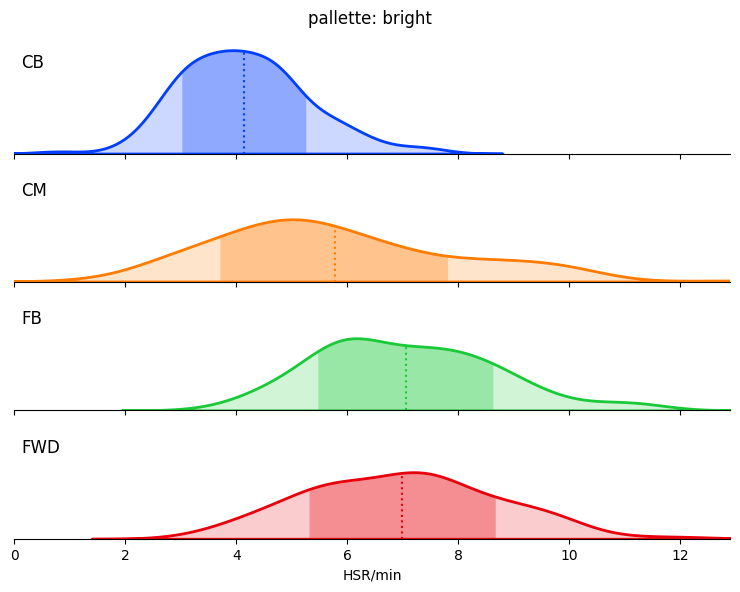

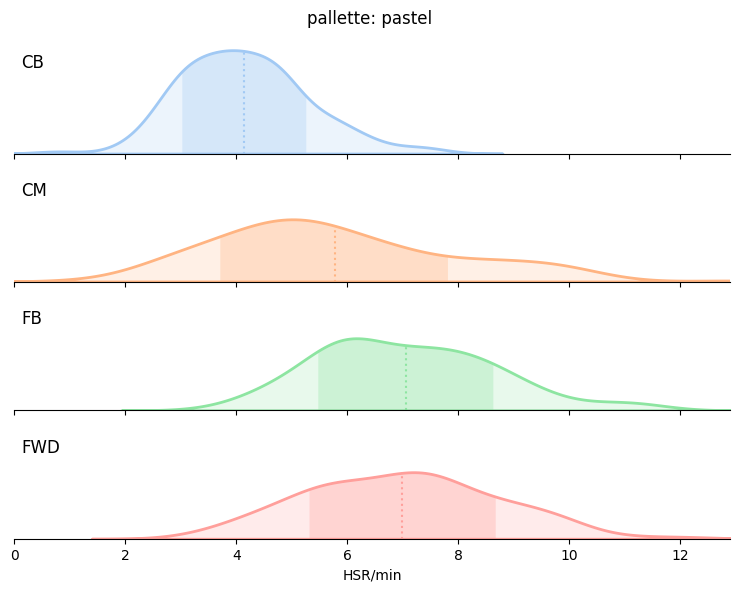

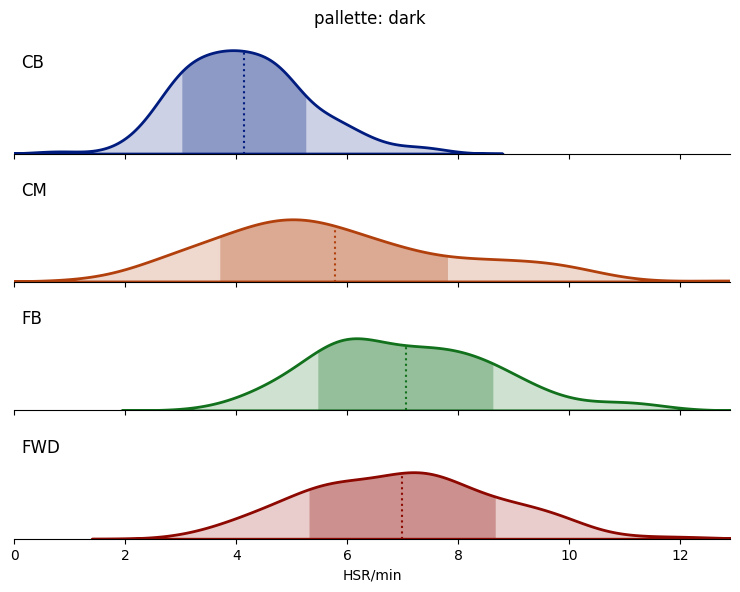

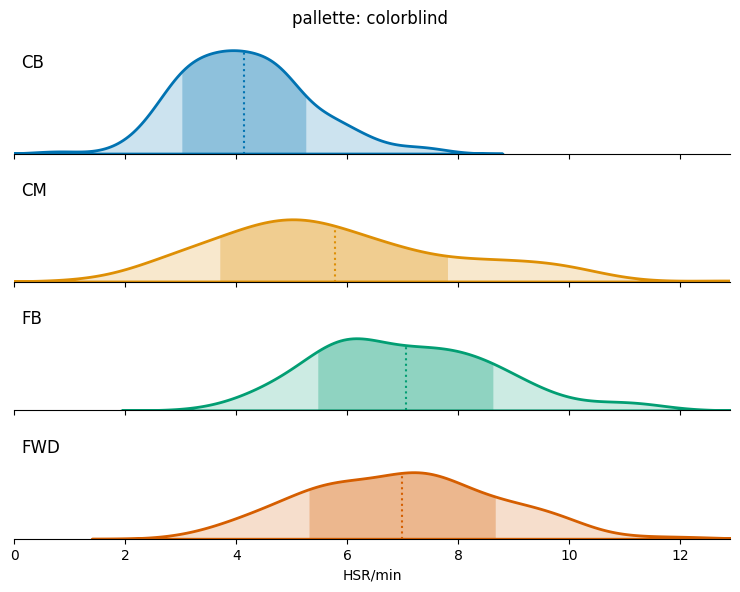

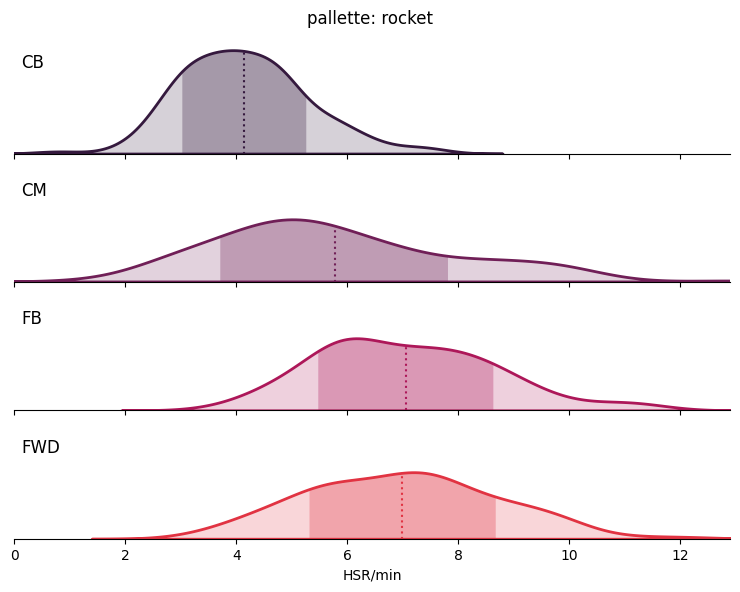

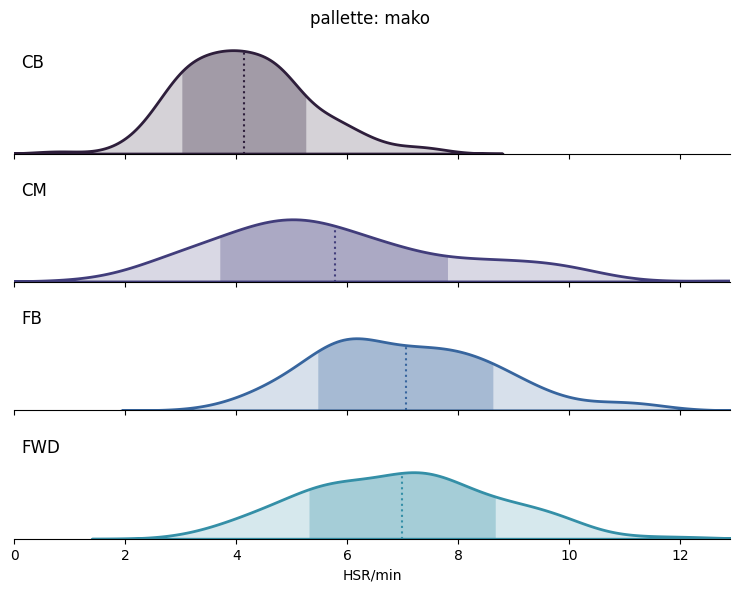

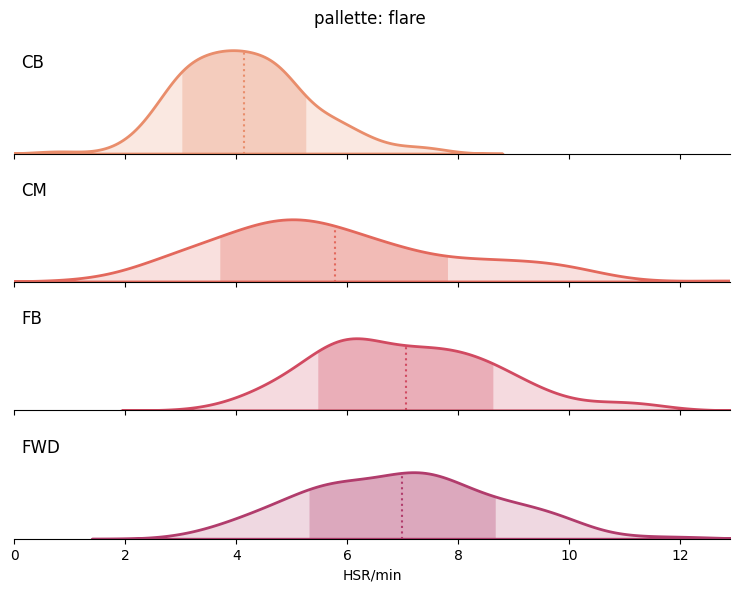

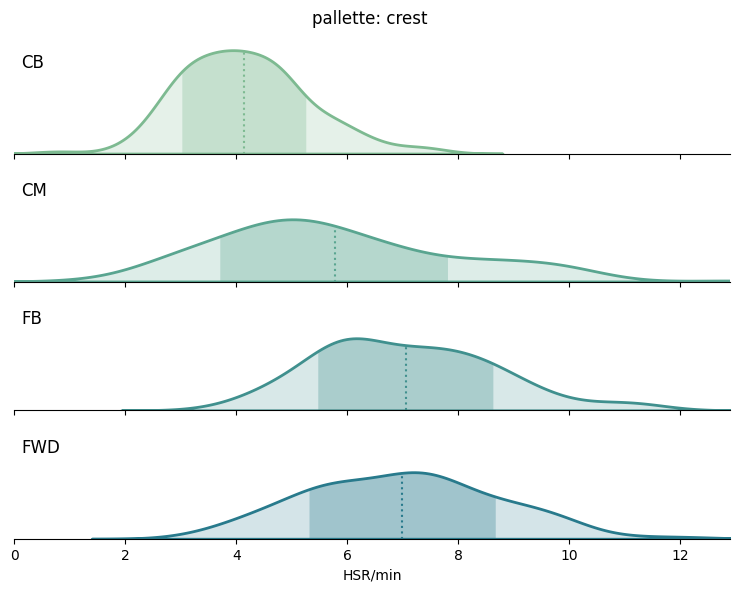

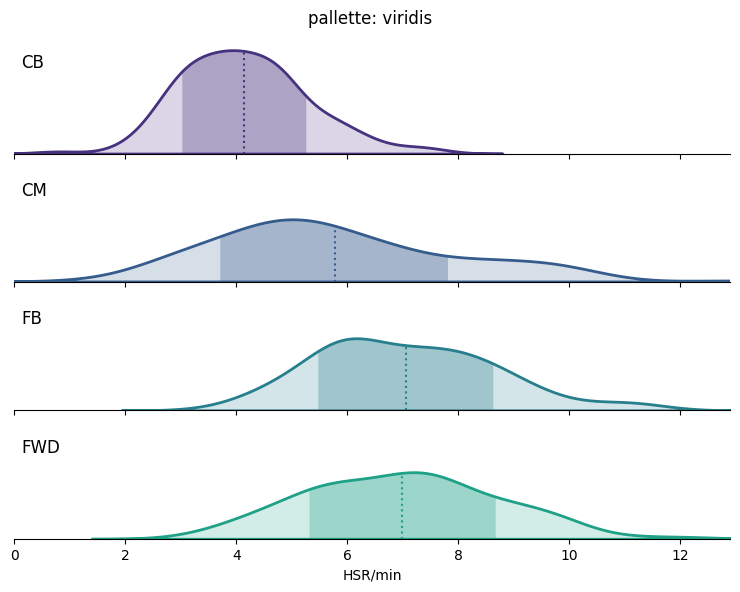

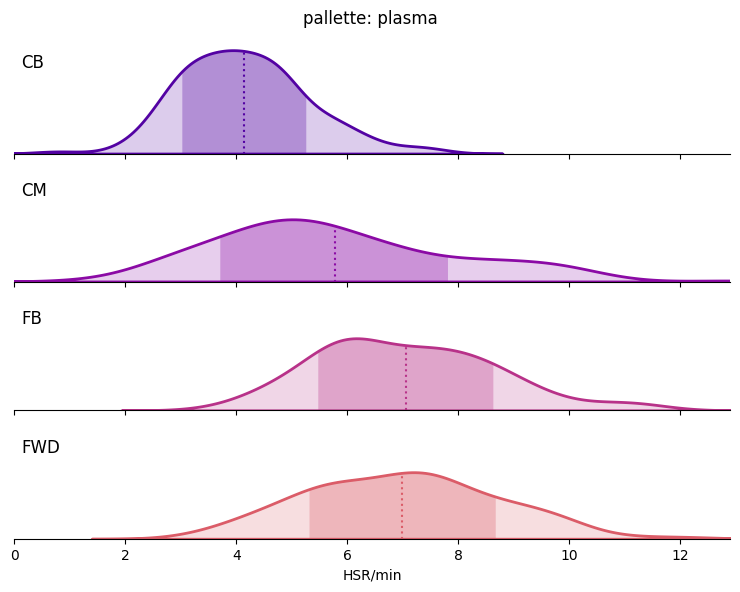

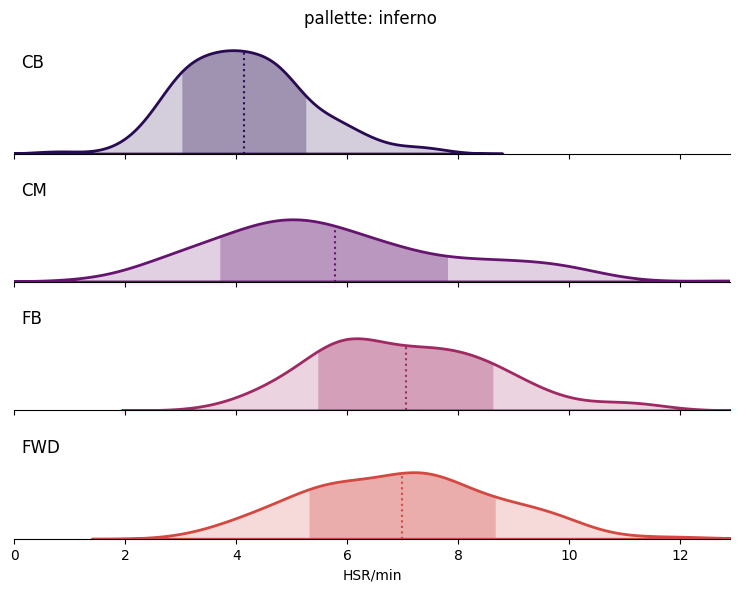

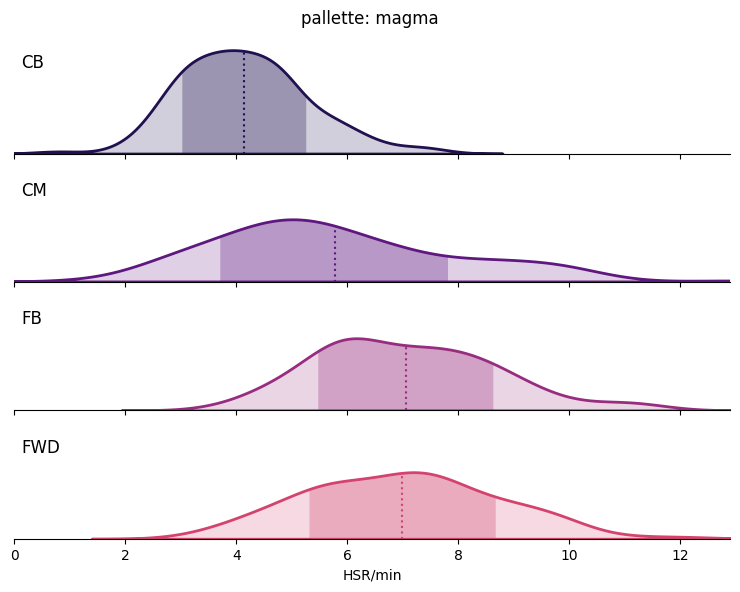

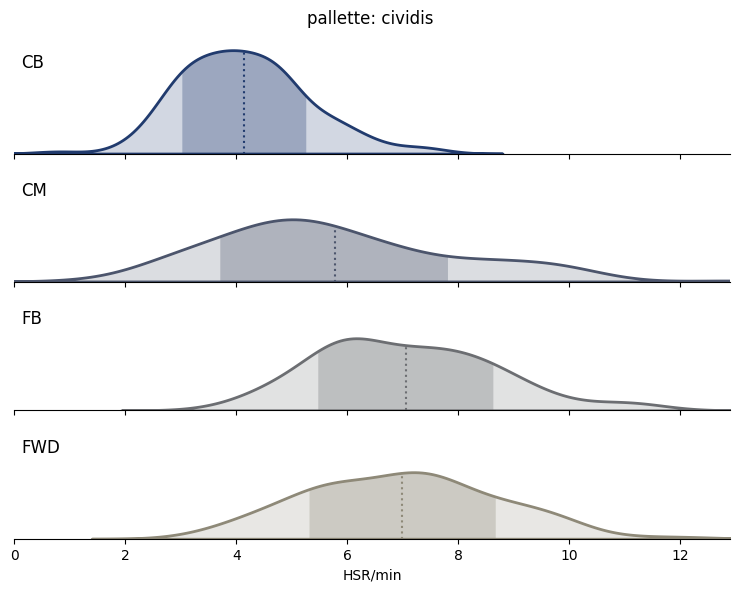

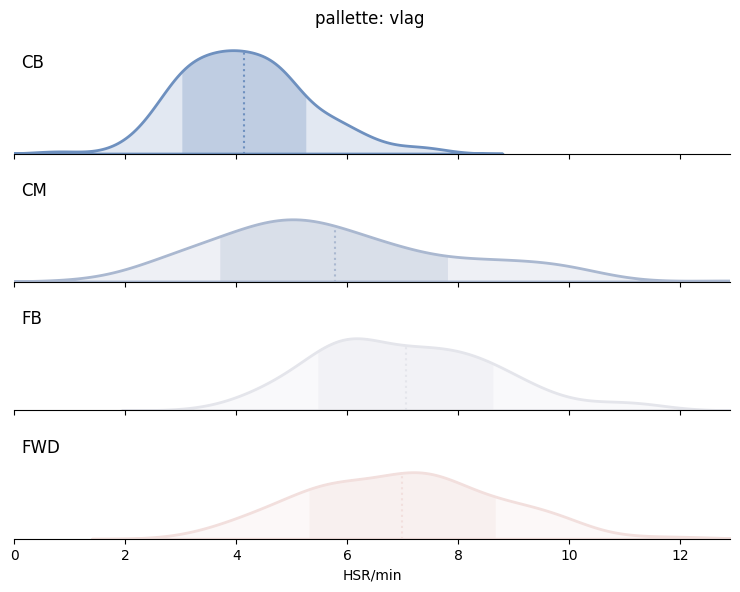

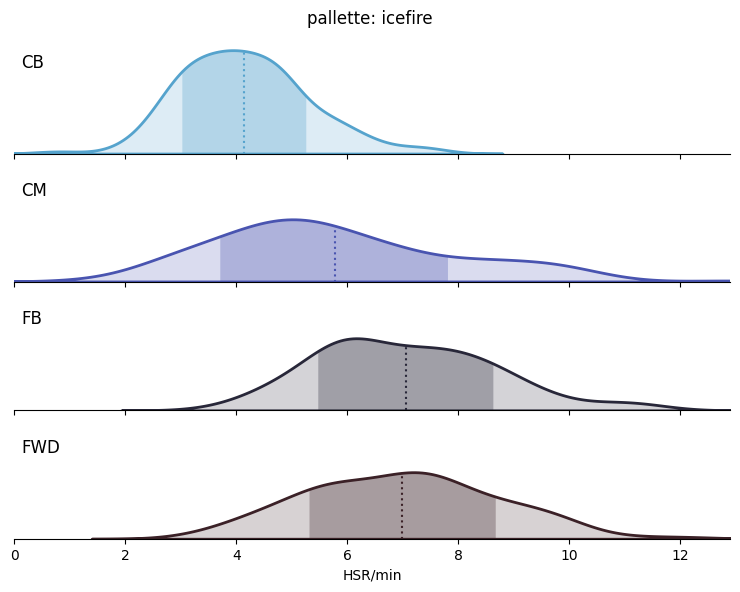

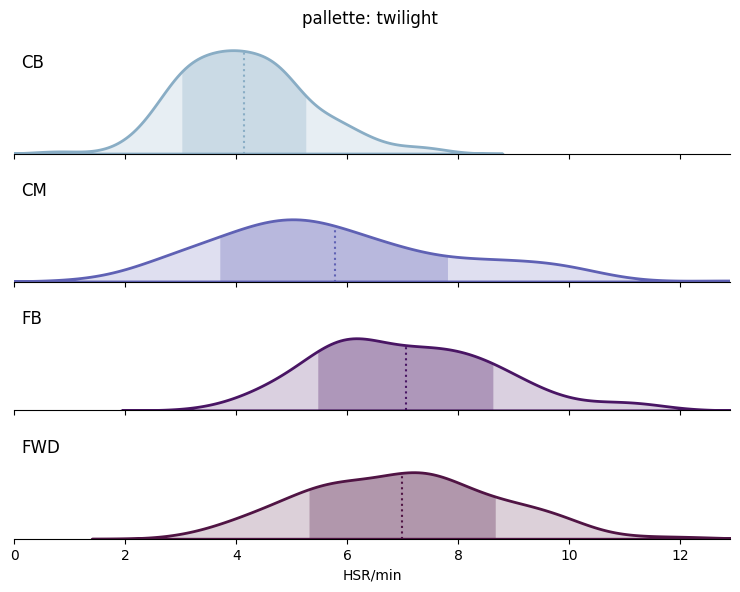

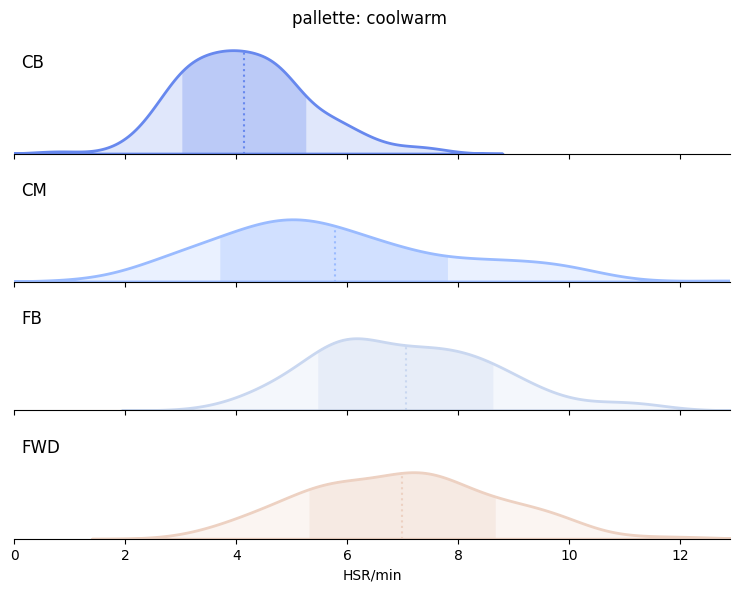

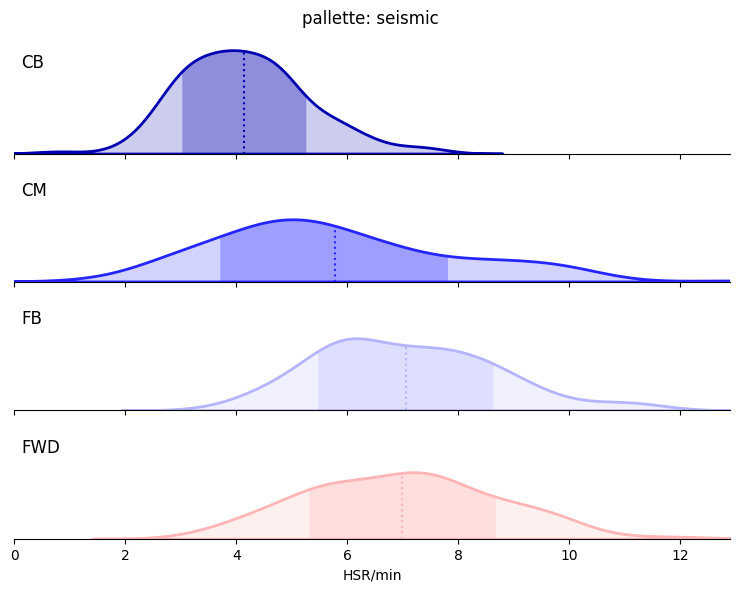

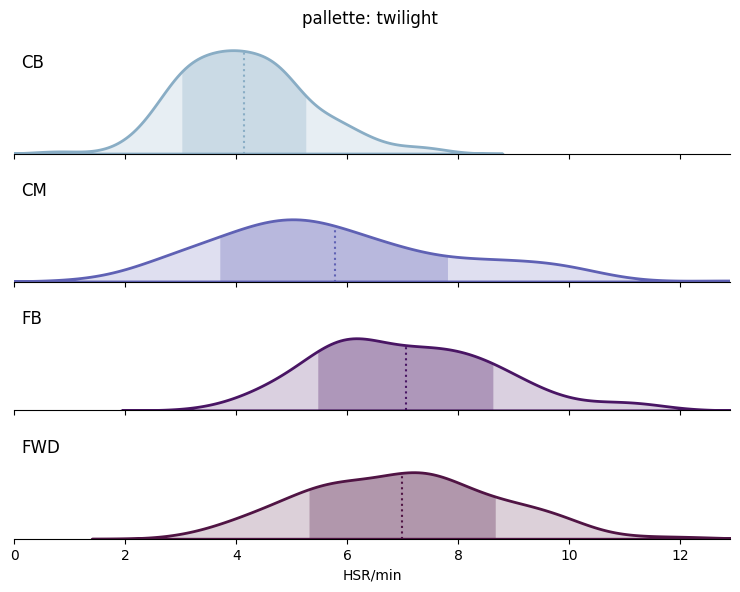

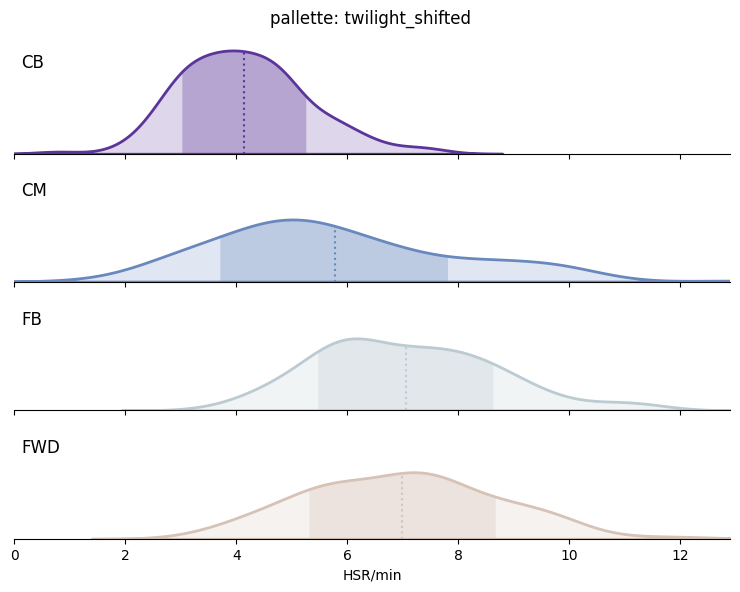

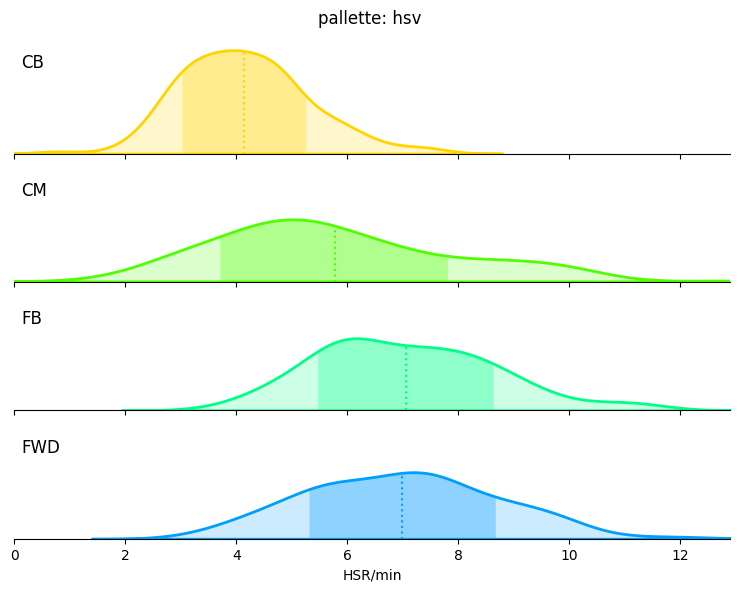

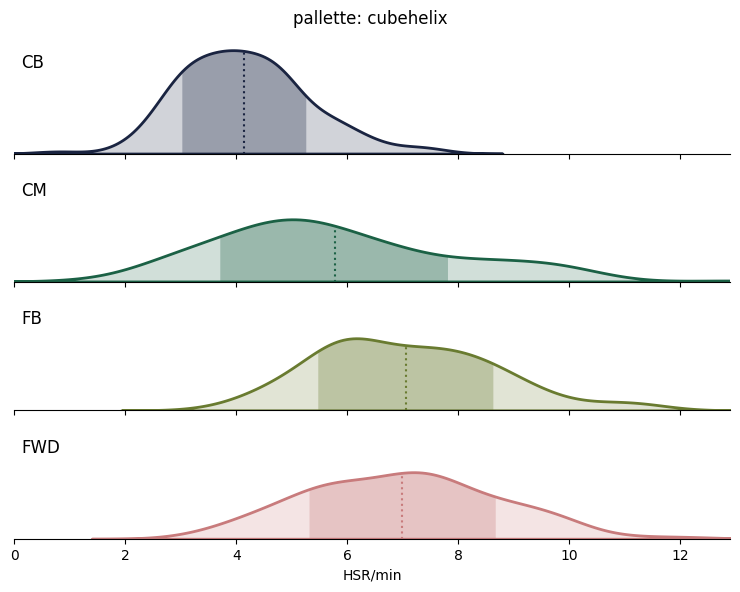

In [68]:
from tqdm import tqdm
seaborn_palettes = [
    # Qualitative Palettes
    "deep", "muted", "bright", "pastel", "dark", "colorblind",
    
    # Sequential Palettes
    "rocket", "mako", "flare", "crest", "viridis", "plasma", "inferno", "magma", "cividis",
    
    # Diverging Palettes
    "vlag", "icefire", "twilight", "coolwarm", "seismic",
    
    # Circular Palettes
    "twilight", "twilight_shifted", "hsv",
    
    # Cubehelix (Customizable)
    "cubehelix",  # Use sns.cubehelix_palette() for customization
    
]

for palette in tqdm(seaborn_palettes):
    # print(f"palette: {palette}")
    generate_RPs_position_row(measure, palette, show_stdv=True)